# PvsNP_1_Definitions
**Auteurs** : Messaoud BERRABAH  
**Date** : 6 mars 2025  
**Licence** : CC-BY 4.0  
---
## Objectif  
Ce notebook introduit les définitions formelles utilisées dans PvsNP_V4.  
Nous y formalisons les concepts de courbure d'Ollivier-Ricci, RHI et NRM, et nous validons leur implémentation sur des graphes simples.  
---


## 📖 Définitions Mathématiques  
Nous utilisons la **courbure d'Ollivier-Ricci** pour mesurer la structure géométrique des graphes.

### Courbure d'Ollivier-Ricci  
Pour un graphe \( G = (V,E) \), la courbure d'une arête \( (u,v) \) est définie par :
\[
\kappa(u,v) = 1 - W_1(\mu_u, \mu_v)
\]
où \( W_1 \) est la distance de Wasserstein entre les distributions de probabilité locales des nœuds \( u \) et \( v \).

### Ricci Hyperbolicity Index (RHI)
\[
RHI(G) = \sigma( \kappa(e) ) \text{ pour } e \in E
\]
où \( \sigma \) est l’écart type des valeurs de courbure.

### Normalized Ricci Mean (NRM)
\[
NRM(G) = \frac{1}{|E|} \sum_{e \in E} \kappa(e)
\]


In [4]:
!pip install POT


In [10]:
# 📌 Importation des bibliothèques essentielles
import sys
import numpy as np
import networkx as nx
import ot  # Optimal Transport pour Ollivier-Ricci
import matplotlib.pyplot as plt
import pandas as pd
import os
from google.colab import drive

# 📌 Fixer un seed pour garantir la reproductibilité
np.random.seed(42)

# 📌 Vérification des versions des bibliothèques
print(f"Python: {sys.version}")
print(f"NumPy: {np.__version__}, NetworkX: {nx.__version__}, OT: {ot.__version__}, Pandas: {pd.__version__}")

# 📌 Montage de Google Drive pour le stockage des résultats
drive.mount('/content/drive')

# 📌 Définition des chemins pour le stockage des résultats
BASE_DIR = "/content/drive/MyDrive/Colab_PvsNP_V4"
DATA_DIR = f"{BASE_DIR}/Data"
RESULTS_DIR = f"{BASE_DIR}/Results"
FIGURES_DIR = f"{BASE_DIR}/Figures"

# 📌 Création des dossiers s'ils n'existent pas
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

print(f"✅ Dossiers créés :\n{DATA_DIR}\n{RESULTS_DIR}\n{FIGURES_DIR}")


Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
NumPy: 1.26.4, NetworkX: 3.4.2, OT: 0.9.5, Pandas: 2.2.2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dossiers créés :
/content/drive/MyDrive/Colab_PvsNP_V4/Data
/content/drive/MyDrive/Colab_PvsNP_V4/Results
/content/drive/MyDrive/Colab_PvsNP_V4/Figures


In [13]:
!git clone https://github.com/MessaoudPvsNP/PvsNP_V4.git

Cloning into 'PvsNP_V4'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [18]:
!mv /content/drive/MyDrive/Colab_PvsNP_V4/PvsNP_1_Definitions.ipynb /content/PvsNP_V4/


mv: cannot stat '/content/drive/MyDrive/Colab_PvsNP_V4/PvsNP_1_Definitions.ipynb': No such file or directory


In [25]:
!mv "/content/drive/MyDrive/Colab Notebooks/PvsNP_1_Definitions.ipynb" "/content/drive/MyDrive/Colab_PvsNP_V4/"




✅ Courbures sauvegardées dans : /content/drive/MyDrive/Colab_PvsNP_V4/Data/curvature_test.csv
✅ Figure du graphe sauvegardée dans : /content/drive/MyDrive/Colab_PvsNP_V4/Figures/graph_annotated.png


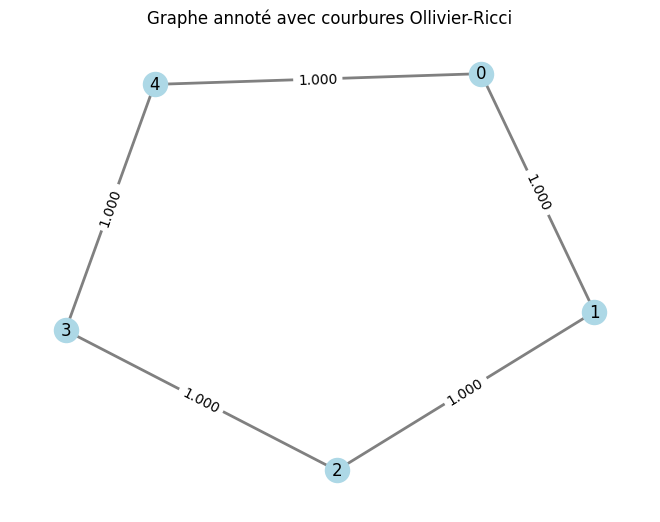

In [12]:
# 📌 Fonction pour calculer la distance de Wasserstein
def wasserstein_distance(mu_u, mu_v):
    """Calcule la distance de Wasserstein entre deux distributions de probabilité"""
    M = np.abs(np.subtract.outer(mu_u, mu_v))  # Matrice de coût
    return ot.emd2(mu_u, mu_v, M)  # Transport optimal

# 📌 Fonction pour calculer la courbure d'Ollivier-Ricci
def ollivier_ricci_curvature(G):
    """Calcule la courbure d'Ollivier-Ricci pour chaque arête du graphe."""
    curvature = {}
    for u, v in G.edges():
        # Création des distributions de probabilité locales
        neighbors_u = list(G.neighbors(u))
        neighbors_v = list(G.neighbors(v))

        # Si un nœud n'a qu'un seul voisin, sa distribution est triviale
        if len(neighbors_u) == 0 or len(neighbors_v) == 0:
            curvature[(u, v)] = 0
            continue

        mu_u = np.ones(len(neighbors_u)) / len(neighbors_u)
        mu_v = np.ones(len(neighbors_v)) / len(neighbors_v)

        # Calcul de la courbure
        kappa = 1 - wasserstein_distance(mu_u, mu_v)
        curvature[(u, v)] = kappa
    return curvature

# 📌 Fonction pour sauvegarder les résultats
def save_curvature_results(curvature, filename="curvature_test.csv"):
    """Sauvegarde les valeurs de courbure dans un fichier CSV"""
    df_curvature = pd.DataFrame(curvature.items(), columns=['Edge', 'Curvature'])
    file_path = f"{DATA_DIR}/{filename}"
    df_curvature.to_csv(file_path, index=False)
    print(f"✅ Courbures sauvegardées dans : {file_path}")

# 📌 Fonction pour afficher et sauvegarder le graphe annoté
def save_graph_figure(G, curvature, filename="graph_annotated.png"):
    """Affiche et sauvegarde le graphe annoté avec les courbures"""
    pos = nx.spring_layout(G)
    edge_labels = {e: f"{curvature[e]:.3f}" for e in G.edges()}
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", width=2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Graphe annoté avec courbures Ollivier-Ricci")

    file_path = f"{FIGURES_DIR}/{filename}"
    plt.savefig(file_path, dpi=300)
    print(f"✅ Figure du graphe sauvegardée dans : {file_path}")

# 📌 Génération d’un graphe simple et calcul des courbures
G = nx.cycle_graph(5)
curvature = ollivier_ricci_curvature(G)

# 📌 Sauvegarde automatique des résultats
save_curvature_results(curvature)
save_graph_figure(G, curvature)